# Task

> ### Finetune SAM model on Custom dataset to segment objects **without prompts**   (during training and inference)

# Approach

![https://github.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/blob/main/support-assets/SAM-promptless-task-specific-finetuning.png](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/main/support-assets/SAM-promptless-task-specific-finetuning.png)

---

### How does SAM work (high-level):
- Sam Encoder --> **ViT + Neck-Module** (Consisting of 2 Conv2D layers used for downsampling the channels of the ViT output)
- The Encoder ViT has a patch-size of **16x16**. 
- Input: **1024x1024x3**
- With the above patch-size and input-image-size, the **number patches formed are: 64x64**
- Output of Encoder: **256x64x64**
- This output goes into the decoder with **Prompt Input** and generates the output

---
### What I tried with code below: 
- Removed the decoder
- Freeze the ViT part of encoder and **un-freeze the Conv2d Neck**
- Add a custom decoder having multiple blocks of: **Conv2d-Transpose + LayerNorm2D + Relu + Dropout** --> ***Added 4 such blocks***
- The input to the decoder will be of shape: **256x64x64** and the output will be of shape: **1024x1024x1**

---
### Dataset Used: 

- https://www.kaggle.com/datasets/swagatajana/football-match-adboards-mask-dataset 

---
### Training: 
- I trained this SAM+Custom-Decoder model on a open kaggle dataset consisting of binary segmentation
- Dataset has **1620 images**. 
- **To prove SAM's capability, I trained this model only on 135 images, ie around 8.3% of the total data just for 11 epochs**

---
### Results: 
- **With a 91% IOU score on a completely random test-set**, the model's results are highly promising, suggesting its potential for real-world applications.
- **IMPORTANT NOTE:** When the same dataset (with same train-test split) was trained using **U2Net**, 
    - with **1346 image (83% of the entire dataset)**
    - and **75 epochs**, 
    - the **IOU score achieved was 91%**. 

- Check the result: ![https://github.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/](https://raw.githubusercontent.com/yogendra-yatnalkar/SAM-Promptless-Task-Specific-Finetuning/main/support-assets/result-sample.png)

- > **(Left-most image is the ground-truth, middle image is the model prediction, right-most image is the input)**


### Installing SAM dependencies and loading the model

In [1]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: wget: command not found


In [19]:
import torch
from torch import nn
import numpy as np 
import os
from segment_anything import sam_model_registry
import glob
import torchvision
import matplotlib.pyplot as plt
import random

# setting global seed 
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# constants
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_path = "/root/ai/dataset/puppy_poo/dataset_seg_mask/"
save_path = "/root/ai/segmenatation/result/poopy_samv3/"
images_folder = "img"
masks_folder = "mask"
batch_size = 1
epochs = 25
t2_batch_size =1
train_split = 0.2

In [20]:
# Loadign the SAM model
sam = sam_model_registry["vit_b"](checkpoint="/root/ai/weights/sam_vit_b_01ec64.pth")
# sam = sam_model_registry["vit_h"](checkpoint="/kaggle/working/sam_vit_h_4b8939.pth")

# moving the sam model to available device
sam = sam.to(device)

In [21]:
for layer_no, param in enumerate(sam.image_encoder.parameters()):
    pass
    
last_layer_no = layer_no
print("Last layer No: ", last_layer_no)

Last layer No:  176


In [22]:
# It seems that the last 6 layers of the model belong to CONV2d neck 
# used in the model to downsample the last attention layer embedding size
for layer_no, param in enumerate(sam.image_encoder.parameters()):
    if(layer_no > (last_layer_no - 6)):
        print(last_layer_no, param.shape)
    
last_layer_no = layer_no
print("Last layer No: ", last_layer_no)

176 torch.Size([256, 768, 1, 1])
176 torch.Size([256])
176 torch.Size([256])
176 torch.Size([256, 256, 3, 3])
176 torch.Size([256])
176 torch.Size([256])
Last layer No:  176


## Building the SAM decoder

In [23]:
# Layer Norm 2D code directly taken from the SAM Repository
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

#### It is observed that the last 6 layers correspond to the Conv2D Neck

- Freeze the ViT
- UnFreeze the Conv2D neck 
- Add a Custom Decoder 

In [24]:
'''
The input of the SAM encoder is: 1024x1024x3
the output of the SAM encoder is: 256x64x64

Hence, having multuple conv2dTranspose to get an output shape of: 1x1024x1024
Note: The last layer of decoder is 1x1 layer such that: 16x1024x1024 -->  1x1024x1024
'''
class SAM_Decoder(nn.Module):
    def __init__(self, sam_encoder, sam_preprocess):
        super().__init__()
        self.sam_encoder = sam_encoder
        self.sam_preprocess = sam_preprocess
        for layer_no, param in enumerate(self.sam_encoder.parameters()):
            if(layer_no > (last_layer_no - 6)):
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        self.nn_drop = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        self.norm1 = LayerNorm2d(128)
        
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        self.norm2 = LayerNorm2d(64)
        
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0)
        self.norm3 = LayerNorm2d(32)
        
        self.conv4 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding = 0)
        self.norm4 = LayerNorm2d(16)
        
        self.conv5 = nn.ConvTranspose2d(16, 1, kernel_size = 1, stride = 1, padding = 0)
        
    def forward(self, x):
        x = self.sam_preprocess(x)
        x = self.sam_encoder(x)
            
        x = self.conv1(x)
        x = self.norm1(x)
        x = torch.nn.functional.relu(x)
        x = self.nn_drop(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv3(x)
        x = self.norm3(x)
        x = torch.nn.functional.relu(x)
        x = self.nn_drop(x)
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.sigmoid(x)
        return x

In [25]:
sam_decoder = SAM_Decoder(sam_encoder = sam.image_encoder, sam_preprocess = sam.preprocess)
sam_decoder = sam_decoder.to(device)

In [26]:
def getNumParams(params):
    numParams, numTrainable = 0, 0
    for param in params:
        npParamCount = np.prod(param.data.shape)
        numParams += npParamCount
        if param.requires_grad:
            numTrainable += npParamCount
    return numParams, numTrainable

print("Number of parameters and number of trainable parameters: ", getNumParams(sam_decoder.parameters()))

Number of parameters and number of trainable parameters:  (89845729, 962273)


#### Total Number of Parameters: **89845729**
#### Total Number of Trainable-Parameters: **962273**

### Building the image data pipeline

In [27]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_path, image_folder, mask_folder):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.base_path = base_path
        self.resize = torchvision.transforms.Resize(
            (1024, 1024),
            interpolation=torchvision.transforms.InterpolationMode.NEAREST
        )
        
        # 모든 이미지 파일 수집
        self.all_img_files = glob.glob(os.path.join(self.base_path, self.image_folder, "*.jpg"))
        
        # 대응되는 마스크 파일이 있는 이미지 파일만 필터링
        self.img_files = []
        for img_path in self.all_img_files:
            filename = os.path.splitext(os.path.basename(img_path))[0]
            mask_path = os.path.join(self.base_path, self.mask_folder, f"{filename}_mask.png")
            if os.path.exists(mask_path):
                self.img_files.append(img_path)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        image_path = self.img_files[index]
        
        # get the mask path
        mask_name = os.path.splitext(os.path.basename(image_path))[0] + "_mask.png"
        # mask_name = mask_name.replace("frame", "mask")
        mask_path = os.path.join(self.base_path, self.mask_folder, mask_name)
        
        # read both image and mask path
        image = torchvision.io.read_image(image_path)
        mask = torchvision.io.read_image(mask_path)
        
        # resizing the image and mask
        image = self.resize(image)
        mask = self.resize(mask)
        
        # chaging dtype of mask
        mask = mask.type(torch.float)
        image = image.type(torch.float)
        
        # standardizing the mask between 0 and 1
        mask = mask/255
    
        return image, mask

### 3 datasets: 

- The original dataset is devided into 3 different sub-sets. 
- This is because, an U2Net was trained earlier on the (training-set + T1 dataset) and T2 dataset was used as the Test/Evaluation Set. 
- **But the prove the capabilities of SAM, we will be training only on  a small sample for the original U2Net train set (which is currently the Train-set + T1 Test-set)**

In [28]:
# 데이터셋 초기화
dataset = ImageDataset(base_path, images_folder, masks_folder)

# 전체 데이터셋 길이
total_len = len(dataset)
print(total_len)
# 비율에 따른 각 데이터셋 길이 계산
train_len = int(total_len * train_split)
t1_len = int(total_len * 0.75)
t2_len = total_len - train_len - t1_len  # 남은 데이터는 t2로

# 데이터셋을 무작위로 섞고 나누기
train_dataset, t1_dataset, t2_dataset = torch.utils.data.random_split(dataset, [train_len, t1_len, t2_len])
# 결과 출력
print("Train set: ", len(train_dataset))
print("T1 set: ", len(t1_dataset))
print("T2 set: ", len(t2_dataset))

1508
Train set:  301
T1 set:  1131
T2 set:  76


In [29]:
# # checking if dataset is ready to go
# dataset = ImageDataset(base_path, images_folder, masks_folder, set_type = "train")

# # split the dataset as train, test1 and test2 datasets
# train_dataset, t1_dataset = torch.utils.data.random_split(dataset, [train_split, 1-train_split])

# # The final test dataset
# t2_dataset = ImageDataset(base_path, images_folder, masks_folder, set_type = "test")

# # print the length of each set
# print("Train set: ", len(train_dataset)) # 0.08
# print("Test1 set: ", len(t1_dataset)) # 0.74
# print("Test2 set: ", len(t2_dataset)) # 0.16

Temp Img shape, Temp Mask shape:  torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
image and mask, device and dtype:  torch.float32 cpu torch.float32 cpu


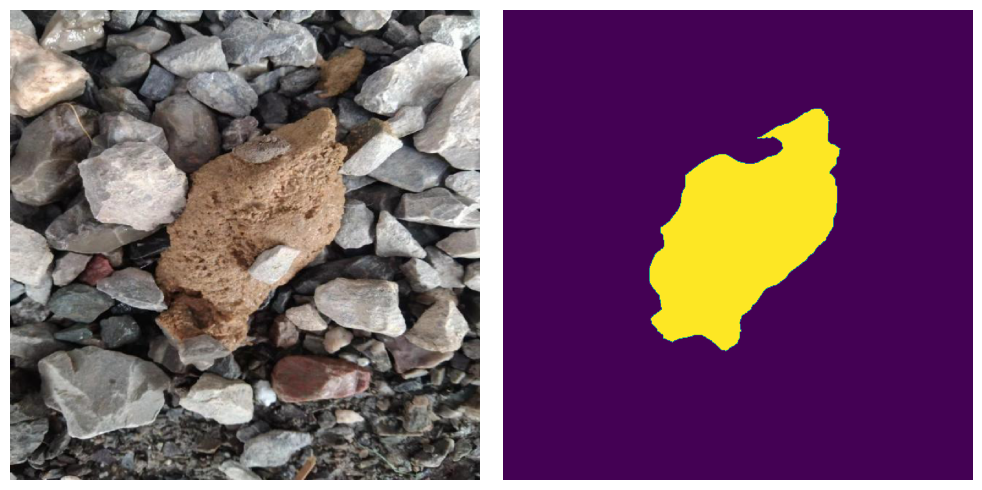

In [30]:
# taking the fist sample and plotting it 
temp_img, temp_mask = train_dataset[0]
print("Temp Img shape, Temp Mask shape: ", temp_img.shape, temp_mask.shape)
print("image and mask, device and dtype: ", temp_img.dtype, temp_img.device, 
      temp_mask.dtype, temp_mask.device)

temp_img_np = temp_img.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

temp_mask_np = temp_mask.to("cpu").numpy()
temp_mask_np = np.transpose(temp_mask_np, [1,2,0])

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(temp_img_np)
# Hide the axes of the first subplot
axs[0].axis('off')
# Display img2 on the second subplot
axs[1].imshow(temp_mask_np)
# Hide the axes of the second subplot
axs[1].axis('off')
# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

### DataLoader

In [31]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=5,
    prefetch_factor=3
)

t1_data_loader = torch.utils.data.DataLoader(
    t1_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=5,
    prefetch_factor=3
)

t2_data_loader = torch.utils.data.DataLoader(
    t2_dataset, 
    batch_size=t2_batch_size,
    shuffle=True,
    num_workers=5,
    prefetch_factor=3
)

In [32]:
data_iter = iter(train_data_loader)
# Get the first batch
batch = next(data_iter)

print("Batch images and masks shape: ", batch[0].shape, batch[1].shape)
print("dtype and device: ", batch[0].dtype, batch[0].device)
print("dtype and device: ", batch[1].dtype, batch[1].device)

Batch images and masks shape:  torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1, 1024, 1024])
dtype and device:  torch.float32 cpu
dtype and device:  torch.float32 cpu


In [33]:
print(device)

cuda:0


In [34]:
temp_decoder_output = sam_decoder(batch[0].to(device))
print(temp_decoder_output.shape)
print(torch.unique(temp_decoder_output))

torch.Size([1, 1, 1024, 1024])
tensor([0.0034, 0.0037, 0.0041,  ..., 0.9153, 0.9180, 0.9227], device='cuda:0',
       grad_fn=<Unique2Backward0>)


In [35]:
# total steps
total_steps = len(train_dataset)//batch_size
print("Total steps in each epoch: ", total_steps)

Total steps in each epoch:  301


## Training on the dataset 

- #### Only using 135 images

In [36]:
# Binary Cross Entropy Loss
bce_loss = torch.nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(sam_decoder.parameters(), lr=0.01)

running_loss = 0.0
mini_batch_event = int(total_steps*0.25)
print("Mini_batch_event: ", mini_batch_event)

for epoch in range(epochs):
    sam_decoder.train()
    epoch_loss = 0
    mini_event_loss = 0
    
    for i, data in enumerate(train_data_loader, 0):
        images, masks = data
        
        # moving them to device
        images = images.to(device)
        masks = masks.to(device)
        
        # zero the parameter 
        optimizer.zero_grad()
        
        pred_masks = sam_decoder(images)
        loss = bce_loss(pred_masks, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        mini_event_loss += loss.item()
        if i % mini_batch_event == 0:    # print every nth mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {mini_event_loss / mini_batch_event:.3f}')
            mini_event_loss = 0
            
    print(f'=====> [{epoch + 1}, {i + 1:5d}] loss: {epoch_loss / total_steps:.3f}')
    
    if(i == 2):
        break

Mini_batch_event:  75
[1,     1] loss: 0.005
[1,    76] loss: 0.259
[1,   151] loss: 0.116
[1,   226] loss: 0.131
[1,   301] loss: 0.108
=====> [1,   301] loss: 0.154
[2,     1] loss: 0.000
[2,    76] loss: 0.117
[2,   151] loss: 0.106
[2,   226] loss: 0.080
[2,   301] loss: 0.117
=====> [2,   301] loss: 0.105
[3,     1] loss: 0.001
[3,    76] loss: 0.076
[3,   151] loss: 0.098
[3,   226] loss: 0.091
[3,   301] loss: 0.086
=====> [3,   301] loss: 0.088
[4,     1] loss: 0.001
[4,    76] loss: 0.081
[4,   151] loss: 0.072
[4,   226] loss: 0.087
[4,   301] loss: 0.061
=====> [4,   301] loss: 0.075
[5,     1] loss: 0.000
[5,    76] loss: 0.110
[5,   151] loss: 0.046
[5,   226] loss: 0.045
[5,   301] loss: 0.055
=====> [5,   301] loss: 0.064
[6,     1] loss: 0.000
[6,    76] loss: 0.080
[6,   151] loss: 0.084
[6,   226] loss: 0.050
[6,   301] loss: 0.037
=====> [6,   301] loss: 0.063
[7,     1] loss: 0.000
[7,    76] loss: 0.104
[7,   151] loss: 0.047
[7,   226] loss: 0.068
[7,   301] loss:

### Setting the model for inference/eval

In [37]:
sam_decoder.eval()
print("SAM model + Custom Decoder set to EVAL mode")

SAM model + Custom Decoder set to EVAL mode


### Plotting few outputs

torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


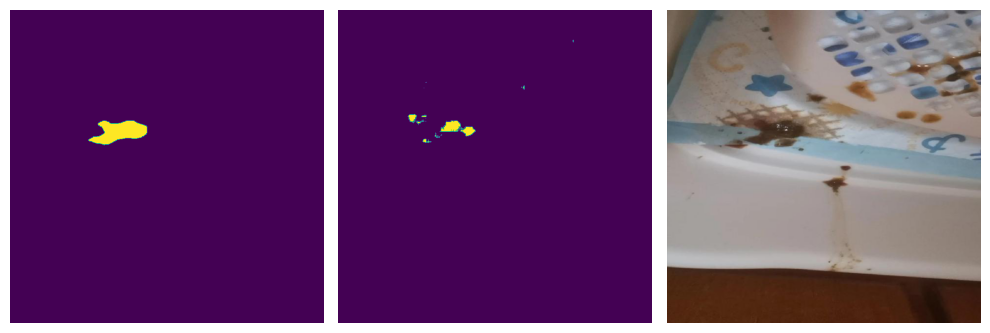

In [38]:
inpt_0, gt_0 = t1_dataset[0][0], t1_dataset[0][1]
with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

torch.Size([1, 1, 1024, 1024])
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


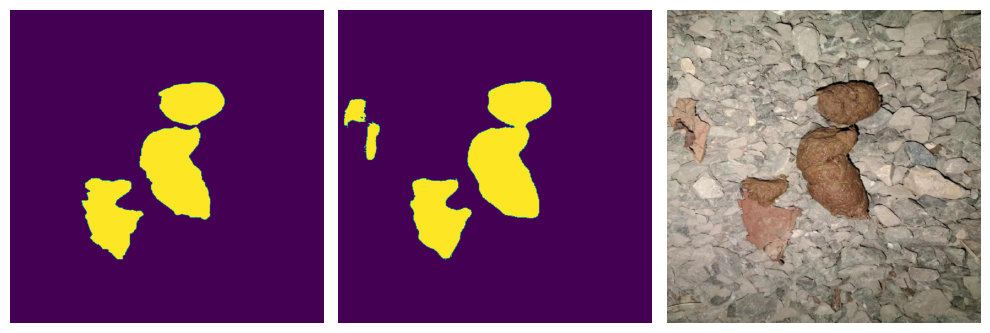

In [39]:
inpt_0, gt_0 = t1_dataset[-1][0], t1_dataset[-1][1]
with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)

decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1, 1024, 1024])
tensor([[[[0.0005, 0.0008, 0.0004,  ..., 0.0008, 0.0003, 0.0005],
          [0.0007, 0.0006, 0.0006,  ..., 0.0006, 0.0005, 0.0006],
          [0.0007, 0.0011, 0.0007,  ..., 0.0014, 0.0015, 0.0028],
          ...,
          [0.0244, 0.0269, 0.0140,  ..., 0.0027, 0.0022, 0.0032],
          [0.0400, 0.0392, 0.0199,  ..., 0.0029, 0.0030, 0.0029],
          [0.0401, 0.0401, 0.0183,  ..., 0.0022, 0.0032, 0.0031]]]],
       device='cuda:0')
[0 1]
Np arr shape:  (1024, 1024, 1) (1024, 1024, 1)


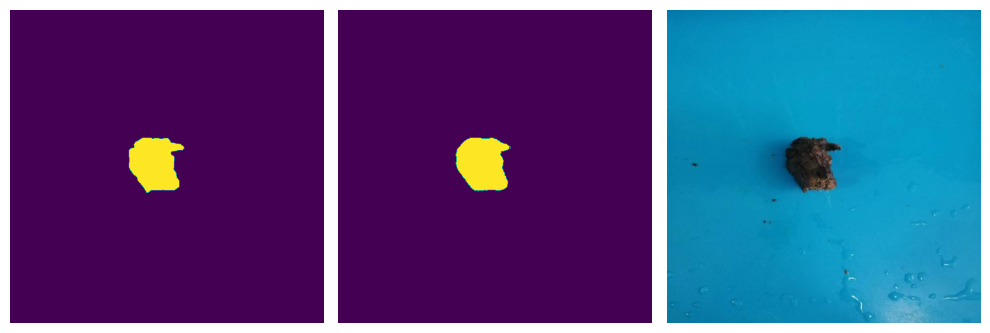

In [40]:
inpt_0, gt_0 = t2_dataset[0][0], t2_dataset[0][1]
print(inpt_0.shape)
print(gt_0.shape)
with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0.to(device).unsqueeze(0))
print(decoder_opt.shape)
print(decoder_opt)
decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
print(np.unique(decoder_opt_np))
gt_0_np = gt_0.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

In [24]:
# 이미지 전처리
import numpy as np
from torchvision import transforms
from PIL import Image


filename = 'Type5_iter45_jpg.rf.d32c838ed75fac55695205d9f9ca08d9'
input_img = f'/root/ai/dataset/mask_1513_split/img/{filename}.jpg'
mask_img = f'/root/ai/dataset/mask_1513_split/mask/{filename}_mask.png'

preprocess = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

image = Image.open(input_img).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)  # 배치 차원 추가
inpt_0 = input_tensor.to(device)
mask = Image.open(mask_img).convert("L")  # 흑백 마스크로 변환
mask_tensor = preprocess(mask).unsqueeze(0)  # 배치 차원 추가

with torch.no_grad():
    decoder_opt = sam_decoder(inpt_0)
print(decoder_opt)
decoder_opt_np = ((decoder_opt > 0.5)*1).to("cpu").numpy()[0].transpose(1,2,0)
print(np.unique(decoder_opt_np))
gt_0_np = mask_tensor.to("cpu").numpy().transpose(1,2,0)
print("Np arr shape: ", decoder_opt_np.shape, gt_0_np.shape)

temp_img_np = inpt_0.to("cpu").numpy()
temp_img_np = np.transpose(temp_img_np, [1,2,0])
temp_img_np = temp_img_np.astype(np.uint8)

# Create a figure with one row and two columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
# Display img1 on the first subplot
axs[0].imshow(gt_0_np)
# Hide the axes of the first subplot
axs[0].axis('off')

# Display img2 on the second subplot
axs[1].imshow(decoder_opt_np)
# Hide the axes of the second subplot
axs[1].axis('off')

# Display img3 on the second subplot
axs[2].imshow(temp_img_np)
# Hide the axes of the second subplot
axs[2].axis('off')

# Adjust the spacing between the subplots
fig.tight_layout()
# Show the figure
plt.show()

tensor([[[[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0001, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0001],
          ...,
          [0.0002, 0.0002, 0.0002,  ..., 0.0001, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0001],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0001, 0.0001]]]],
       device='cuda:0')
[0]


ValueError: axes don't match array

### T1 Dataset Loss

In [41]:
t1_total_steps = len(t1_dataset)//batch_size
print("T1 total steps: ", t1_total_steps)
with torch.no_grad():
    t1_loss = 0
    for i, test_data in enumerate(t1_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        test_inputs, test_labels = test_data

        # moving to device
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        pred_masks = sam_decoder(test_inputs)
        t1_step_loss = bce_loss(pred_masks, test_labels)
        
        t1_loss += t1_step_loss
        
print(f'-------------> Test T1 Loss: {t1_loss / t1_total_steps:.3f}')

T1 total steps:  1131
-------------> Test T1 Loss: 0.048


### T2 dataset loss

In [42]:
t2_total_steps = len(t2_dataset)//t2_batch_size
print("T1 total steps: ", t2_total_steps)
iou_loss_li = []

with torch.no_grad():
    t2_loss = 0
    for i, test_data in enumerate(t2_data_loader, 0):
        if(i%int(t2_total_steps*0.20) == 0):
            print(i)
        # get the inputs; data is a list of [inputs, labels]
        test_inputs, test_labels = test_data

        # moving to device
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        # Prediction
        pred_masks = sam_decoder(test_inputs)
        
        # BCE loss
        t2_step_loss = bce_loss(pred_masks, test_labels)
        t2_loss += t2_step_loss
        
        # IOU loss
        intersection = torch.logical_and((pred_masks > 0.5)*1.0, test_labels)
        union = torch.logical_or((pred_masks > 0.5)*1.0, test_labels)
        iou = torch.sum(intersection) / torch.sum(union)
        iou_loss_li.append(iou)
        
print(f'-------------> Test T1 Loss: {t2_loss / t2_total_steps:.3f}')
# print(f'-------------> Test T1 IOU Loss: {iou_loss_li}')
print("IOU LOSS: ", sum(iou_loss_li)/(len(iou_loss_li)))

T1 total steps:  76
0
15
30
45
60
75
-------------> Test T1 Loss: 0.056
IOU LOSS:  tensor(0.7997, device='cuda:0')


In [43]:
print(sum(iou_loss_li)/(len(iou_loss_li)))

tensor(0.7997, device='cuda:0')


## Saving the model

In [44]:
torch.save(sam_decoder.state_dict(), os.path.join(save_path, "sam_enc_custom_decoder.pt"))

In [ ]:


sam_checkpoint = "/root/ai/sam/result/promptless_1513/sam_enc_custom_decoder.pt"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)